# Compare prediction

In [1]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")
sys.path.insert(0,"..")

import json
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import string
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from tree.parameters import Ts
from tree.utils import linestyles, markers

In [2]:
hbi_unc_df = pd.read_csv("../data/hbi_unc.csv")

with open("../data/splits/random.json", "r") as f:
    train_inds, test_inds = json.load(f)

num_training = len(train_inds)

test_df = hbi_unc_df.loc[test_inds, :]
test_df = test_df.reset_index(drop=True)

# Load test results

In [3]:
sidt_df_dict = {}
fractions = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
run_dirs = {
    "../models/split-random_run-basecase": "BC",
    "../models/split-random_run-basecase-bounded": "BC_UB",
    "../models/split-random_run-aleatoric-prepruning-bounded": "AP_UB",
    "../models/split-random_run-model-variance-prepruning-0.05-bounded": "MP0.05_UB",
    "../models/split-random_run-model-variance-prepruning-0.005-bounded": "MP0.005_UB",
    "../models/split-random_run-model-variance-prepruning-0.001-bounded": "MP0.001_UB",
    "../models/split-random_run-model-variance-prepruning-0.0005-bounded": "MP0.0005_UB",
}
for run_dir in run_dirs:
    for frac in fractions:
        sidt_df = pd.read_csv(f"{run_dir}/frac-{frac}/test.csv")
        sidt_df_dict[run_dirs[run_dir], frac] = sidt_df

# Get tree size

In [4]:
tree_sizes = {}
for run_dir in run_dirs:
    for frac in fractions:
        tree_path = f"{run_dir}/frac-{frac}/tree.py"
        with open(tree_path, "r") as f:
            lines = f.readlines()
            tree_size = sum("index = " in line for line in lines)
            tree_sizes[run_dirs[run_dir], frac] = tree_size
            
# tree_sizes

# Get RMSE/MAE

In [5]:
temp_dict = {
    "Fraction of training data": [],
    "Number of training data": [],
    "run_dir": [],
    "tree_size": [],
}

for column in test_df.columns:
    if column.startswith("HBI_"):
        temp_dict["rmse_"+column] = []
        temp_dict["mae_"+column] = []
        temp_dict["bounded_"+column] = []

for (run_dir, frac), sidt_df in sidt_df_dict.items():
    temp_dict["Fraction of training data"].append(frac)
    temp_dict["Number of training data"].append(frac * num_training)
    temp_dict["run_dir"].append(run_dir)
    temp_dict["tree_size"].append(tree_sizes[run_dir, frac])
    for column in test_df.columns:
        if column.startswith("HBI_"):
            true_ys = test_df[column]
            pred_ys = sidt_df[column]
            temp_dict["rmse_"+column].append(np.sqrt(mean_squared_error(true_ys, pred_ys)))
            temp_dict["mae_"+column].append(mean_absolute_error(true_ys, pred_ys))
            
            pred_unc = sidt_df["unc_"+column]
            true_err = (sidt_df[column] - test_df[column]).abs()
            data_unc = test_df["unc_"+column]
            temp_dict["bounded_"+column].append(sum((pred_unc >= true_err)) / len(pred_unc))

result_df = pd.DataFrame(temp_dict)
# result_df

# Plot: BC vs. BC_UB

## Bounded uncertainty vs. training fraction

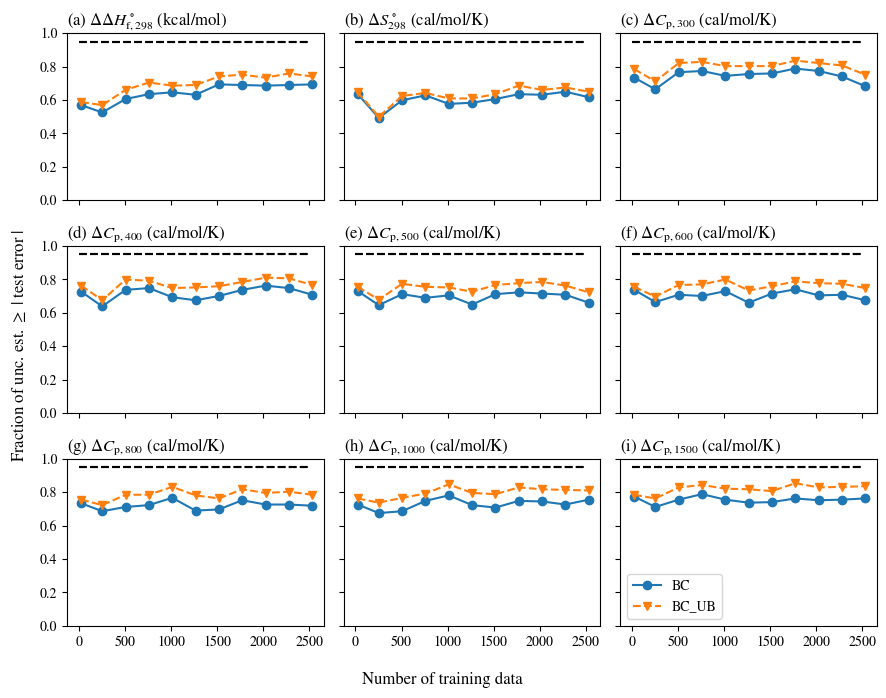

In [6]:
run_dirs_to_plot = ["BC", "BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, sharex=True, figsize=(9, 7))
bins = 20

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "bounded_HBI_H298 (kcal/mol)"
        ax.hlines(0.95, xmin=0, xmax=2500, linestyle="--", color="k")
        ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_ylim([0, 1])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "bounded_HBI_Sint298 (cal/mol/K)"
        ax.hlines(0.95, xmin=0, xmax=2500, linestyle="--", color="k")
        ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_ylim([0, 1])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"bounded_HBI_Cp{T} (cal/mol/K)"
            ax.hlines(0.95, xmin=0, xmax=2500, linestyle="--", color="k")
            ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_ylim([0, 1])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")
            
        counter+=1

axs.flat[-1].legend()
fig.supylabel("Fraction of unc. est. $\geq$ | test error |")
fig.supxlabel("Number of training data")

fig.tight_layout()
fig.savefig("../figures/bounded_uncertainty_frac_vs_training_frac.pdf", bbox_inches="tight")

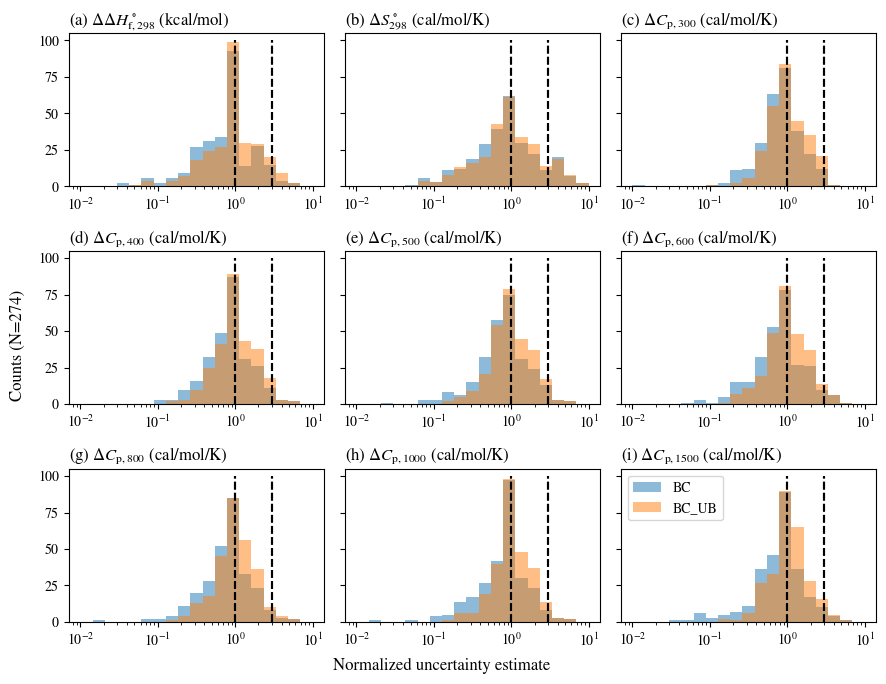

In [8]:
run_dirs_to_plot = ["BC", "BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 7), sharey=True)

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        
        sidt_df = sidt_df_dict[run_dirs[run_dir], 1.0]
        
        ax = axs.flat[0]
        label = "HBI_H298 (kcal/mol)"
        true_ys = test_df[label].values
        data_uncs = test_df["unc_"+label].values
        pred_ys = sidt_df[label].values
        pred_uncs = sidt_df["unc_"+label].values
        test_errs = np.abs(pred_ys - true_ys)
        xs = pred_uncs / np.sqrt(test_errs**2 + data_uncs**2)
        # xs = pred_uncs / test_errs
        logbins = np.geomspace(1e-2, 1e1, 20)
        ax.hist(xs, bins=logbins, alpha=0.5, label=run_dirs[run_dir])
        ax.vlines(x=3, ymin=0, ymax=100, linestyle="--", color="k")
        ax.vlines(x=1, ymin=0, ymax=100, linestyle="--", color="k")
        # ax.scatter([2], [80], marker="*", color="k")
        ax.set_xscale("log")
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "HBI_Sint298 (cal/mol/K)"
        true_ys = test_df[label].values
        data_uncs = test_df["unc_"+label].values
        pred_ys = sidt_df[label].values
        pred_uncs = sidt_df["unc_"+label].values
        test_errs = np.abs(pred_ys - true_ys)
        xs = pred_uncs / np.sqrt(test_errs**2 + data_uncs**2)
        # xs = pred_uncs / test_errs
        logbins = np.geomspace(1e-2, 1e1, 20)
        ax.hist(xs, bins=logbins, alpha=0.5, label=run_dirs[run_dir])
        ax.vlines(x=3, ymin=0, ymax=100, linestyle="--", color="k")
        ax.vlines(x=1, ymin=0, ymax=100, linestyle="--", color="k")
        ax.set_xscale("log")
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"HBI_Cp{T} (cal/mol/K)"
            true_ys = test_df[label].values
            data_uncs = test_df["unc_"+label].values
            pred_ys = sidt_df[label].values
            pred_uncs = sidt_df["unc_"+label].values
            test_errs = np.abs(pred_ys - true_ys)
            xs = pred_uncs / np.sqrt(test_errs**2 + data_uncs**2)
            # xs = pred_uncs / test_errs
            logbins = np.geomspace(1e-2, 1e1, 20)
            ax.hist(xs, bins=logbins, alpha=0.5, label=run_dirs[run_dir])
            ax.vlines(x=3, ymin=0, ymax=100, linestyle="--", color="k")
            ax.vlines(x=1, ymin=0, ymax=100, linestyle="--", color="k")
            ax.set_xscale("log")
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")
            
        counter += 1

axs.flat[-1].legend()
fig.supylabel("Counts "+f"(N={len(test_df.index)})")
fig.supxlabel(f"Normalized uncertainty estimate", y=0.03)
fig.tight_layout()


fig.savefig("../figures/sidt_unc_div_true_error_vs_true_error_BC_vs_BC_UB.pdf", bbox_inches="tight")

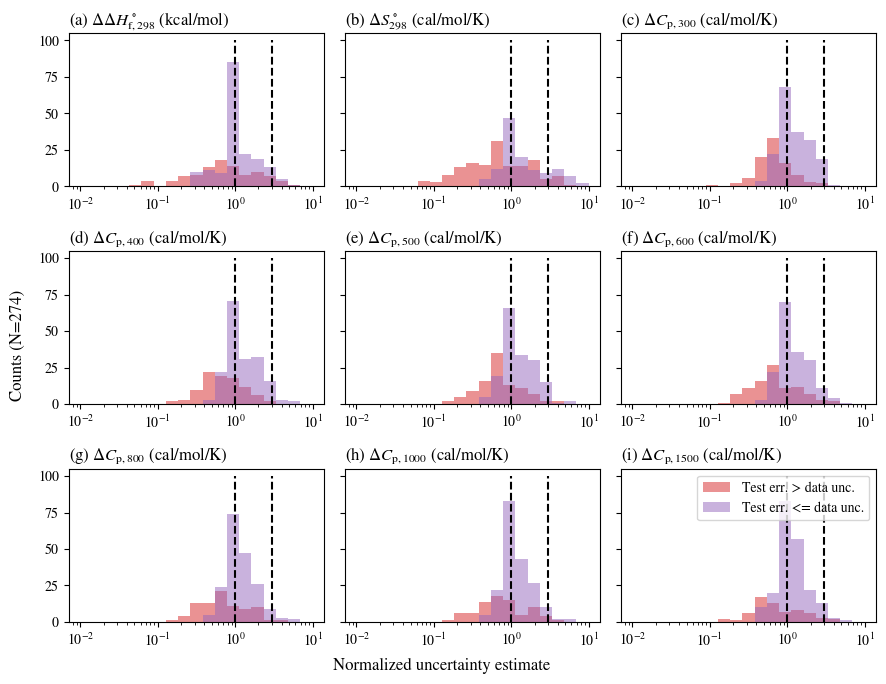

In [9]:
run_dirs_to_plot = ["BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 7), sharey=True)

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        
        sidt_df = sidt_df_dict[run_dirs[run_dir], 1.0]
        
        ax = axs.flat[0]
        label = "HBI_H298 (kcal/mol)"
        true_ys = test_df[label].values
        data_uncs = test_df["unc_"+label].values
        pred_ys = sidt_df[label].values
        pred_uncs = sidt_df["unc_"+label].values
        test_errs = np.abs(pred_ys - true_ys)
        xs = pred_uncs / np.sqrt(test_errs**2 + data_uncs**2)
        # xs = pred_uncs / test_errs
        logbins = np.geomspace(1e-2, 1e1, 20)
        ax.hist(xs[test_errs>data_uncs], bins=logbins, alpha=0.5, label="Test err. > data unc.", color="C3")
        ax.hist(xs[test_errs<=data_uncs], bins=logbins, alpha=0.5, label="Test err. <= data unc.", color="C4")
        ax.vlines(x=3, ymin=0, ymax=100, linestyle="--", color="k")
        ax.vlines(x=1, ymin=0, ymax=100, linestyle="--", color="k")
        ax.set_xscale("log")
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "HBI_Sint298 (cal/mol/K)"
        true_ys = test_df[label].values
        data_uncs = test_df["unc_"+label].values
        pred_ys = sidt_df[label].values
        pred_uncs = sidt_df["unc_"+label].values
        test_errs = np.abs(pred_ys - true_ys)
        xs = pred_uncs / np.sqrt(test_errs**2 + data_uncs**2)
        # xs = pred_uncs / test_errs
        logbins = np.geomspace(1e-2, 1e1, 20)
        ax.hist(xs[test_errs>data_uncs], bins=logbins, alpha=0.5, label="Test err. > data unc.", color="C3")
        ax.hist(xs[test_errs<=data_uncs], bins=logbins, alpha=0.5, label="Test err. <= data unc.", color="C4")
        ax.vlines(x=3, ymin=0, ymax=100, linestyle="--", color="k")
        ax.vlines(x=1, ymin=0, ymax=100, linestyle="--", color="k")
        ax.set_xscale("log")
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"HBI_Cp{T} (cal/mol/K)"
            true_ys = test_df[label].values
            data_uncs = test_df["unc_"+label].values
            pred_ys = sidt_df[label].values
            pred_uncs = sidt_df["unc_"+label].values
            test_errs = np.abs(pred_ys - true_ys)
            xs = pred_uncs / np.sqrt(test_errs**2 + data_uncs**2)
            # xs = pred_uncs / test_errs
            logbins = np.geomspace(1e-2, 1e1, 20)
            ax.hist(xs[test_errs>data_uncs], bins=logbins, alpha=0.5, label="Test err. > data unc.", color="C3")
            ax.hist(xs[test_errs<=data_uncs], bins=logbins, alpha=0.5, label="Test err. <= data unc.", color="C4")
            ax.vlines(x=3, ymin=0, ymax=100, linestyle="--", color="k")
            ax.vlines(x=1, ymin=0, ymax=100, linestyle="--", color="k")
            ax.set_xscale("log")
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")
            
        counter += 1

axs.flat[-1].legend()
fig.supylabel("Counts "+f"(N={len(test_df.index)})")
fig.supxlabel(f"Normalized uncertainty estimate", y=0.03)
fig.tight_layout()


fig.savefig("../figures/BC_UB_unc_est_hist_err_gt_unc_vs_err_leq_unc.pdf", bbox_inches="tight")

# Plot: BC_UB vs. AP_UB

## Reduction factor vs. training size

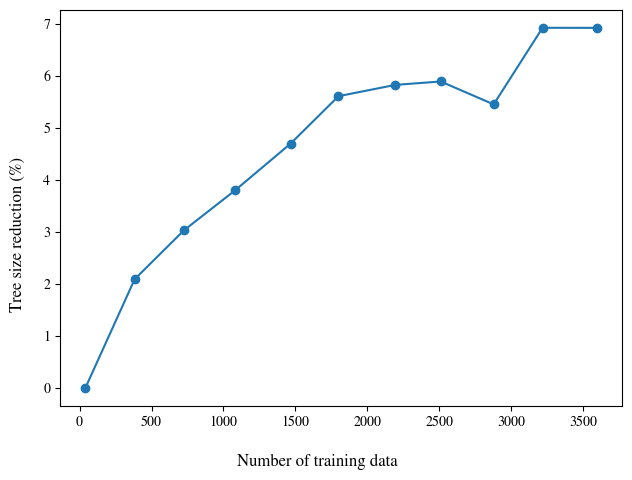

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=1)

ax = axs
reduction_fractions = (result_df.loc[result_df["run_dir"]=="BC_UB", "tree_size"].values - result_df.loc[result_df["run_dir"]=="AP_UB", "tree_size"].values) / result_df.loc[result_df["run_dir"]=="BC_UB", "tree_size"].values
ax.plot(result_df.loc[result_df["run_dir"]=="BC_UB", "tree_size"], reduction_fractions * 100, color="C0", marker="o",)

fig.supxlabel("Number of training data")
fig.supylabel("Tree size reduction (%)")
fig.tight_layout()
fig.savefig("../figures/BC_UB_vs_AP_UB_tree_size_reduction_vs_num_training.pdf", bbox_inches="tight")

## RMSE/MAE vs. training fraction

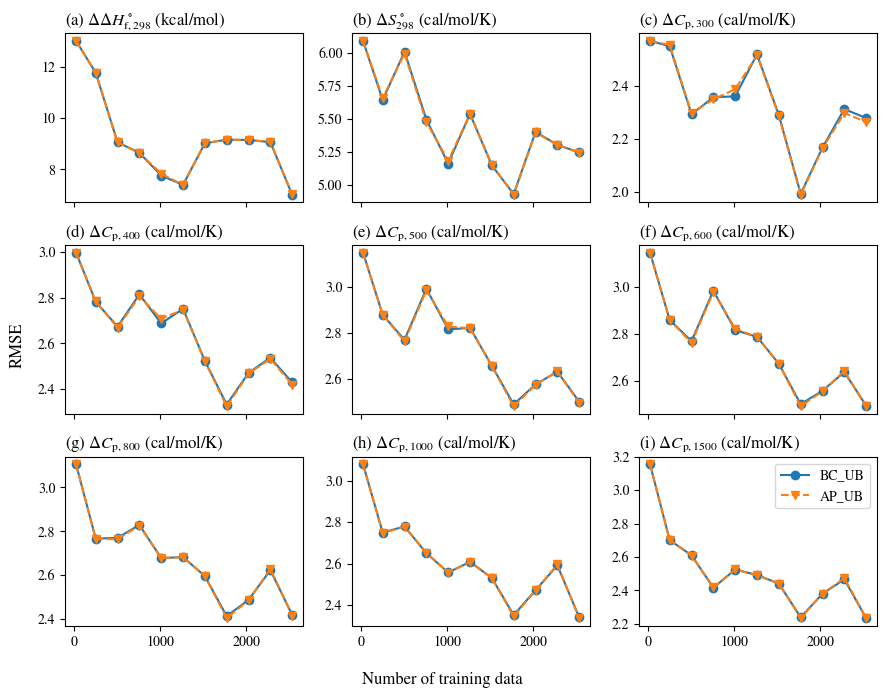

In [11]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Number of training data")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_training_frac_BC_vs_AP.pdf", bbox_inches="tight")

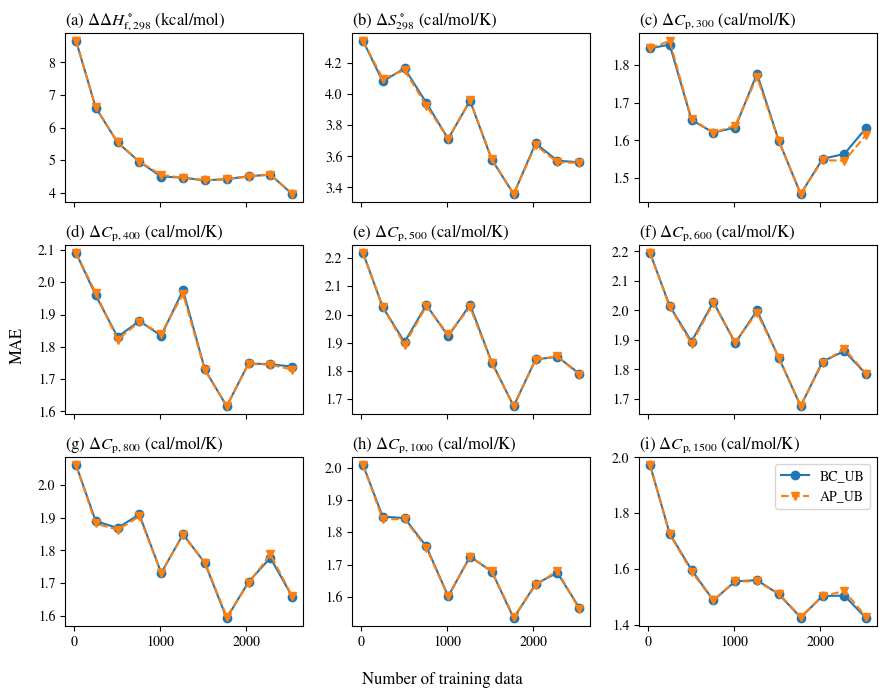

In [12]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"MAE")
fig.supxlabel(f"Number of training data")

fig.tight_layout()
fig.savefig("../figures/mae_vs_training_frac_BC_vs_AP.pdf", bbox_inches="tight")

# MP vs. AP

## RMSE/MAE vs. training fraction

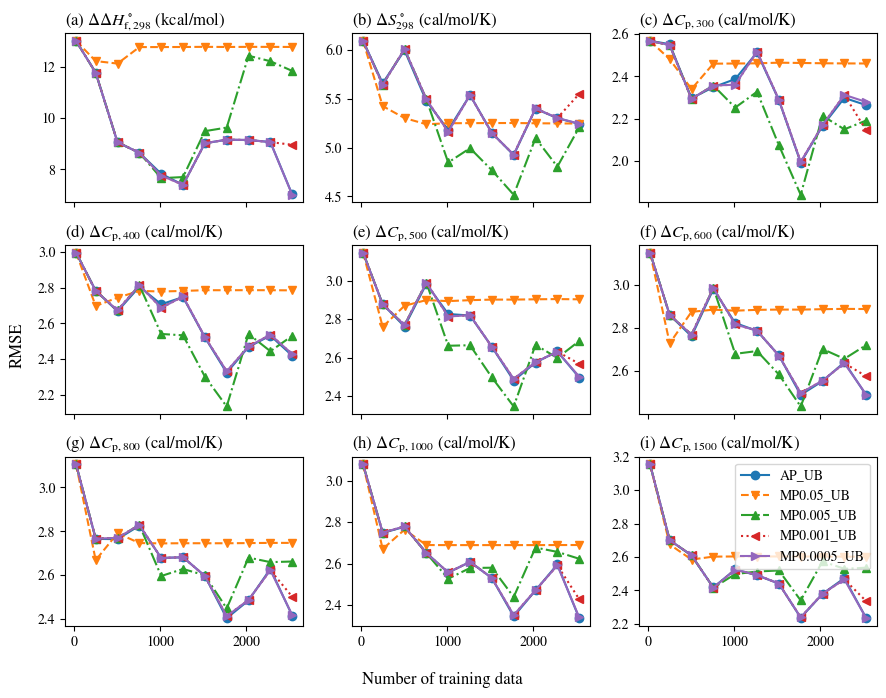

In [13]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "MP0.0005_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Number of training data")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_training_frac_AP_vs_MP.pdf", bbox_inches="tight")

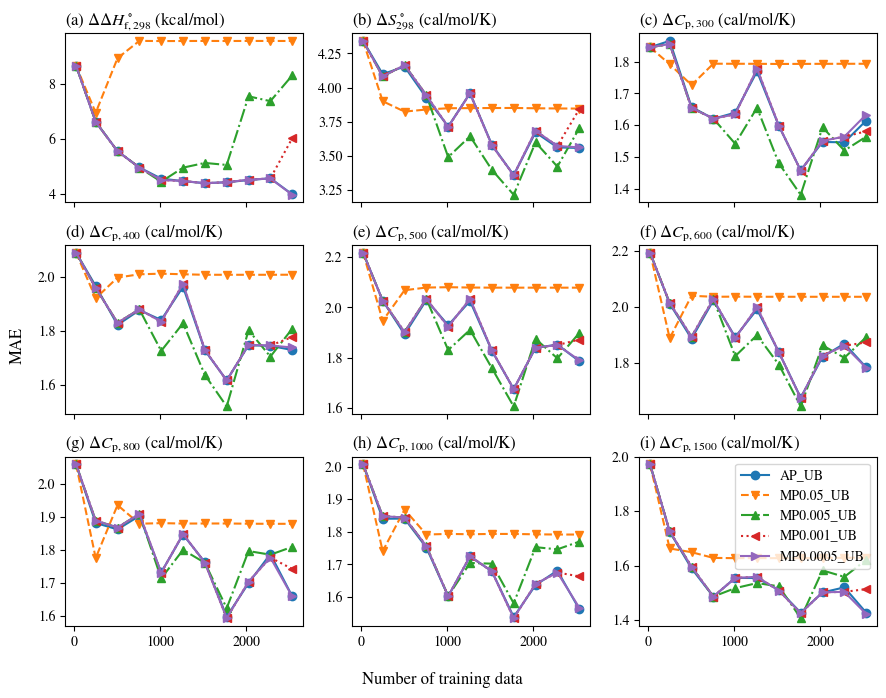

In [14]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "MP0.0005_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dirs[run_dir], "Number of training data"], result_df.loc[result_df["run_dir"]==run_dirs[run_dir], label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"MAE")
fig.supxlabel(f"Number of training data")

fig.tight_layout()
fig.savefig("../figures/mae_vs_training_frac_AP_vs_MP.pdf", bbox_inches="tight")